In [1]:
import pandas as pd
import json
import re

# Acquiring Data

In [2]:
#Video source: https://www.youtube.com/watch?v=529LYDgRTgQ, https://www.youtube.com/watch?v=aAy-B6KPld8
import sqlalchemy as db

engine = db.create_engine("sqlite:///chinook.db")
connection = engine.connect()
metadata = db.MetaData()

In [3]:
artists = db.Table('artists', metadata, autoload_with=engine)
tracks = db.Table('tracks', metadata, autoload_with=engine)
albums = db.Table('albums', metadata, autoload_with=engine)

In [4]:
query = db.select(
    artists.c.Name.label("Artist"),
    tracks.c.Name.label("Track")
).select_from(
    artists
    .join(albums, artists.c.ArtistId == albums.c.ArtistId)
    .join(tracks, albums.c.AlbumId == tracks.c.AlbumId)
)

results = connection.execute(query).fetchall()
combined = pd.DataFrame(results, columns=["Artist", "Track"])
combined.head()


,Artist,Track
0,AC/DC,For Those About To Rock (We Salute You)
1,AC/DC,Put The Finger On You
2,AC/DC,Let's Get It Up
3,AC/DC,Inject The Venom
4,AC/DC,Snowballed


# Data Manipulation

In [5]:
# This regex splits on: &, /, Feat., 
capture = r"\s+(?:&|/|,|Feat\.)\s+"

combined_2 = combined.copy()
combined_2["Artist"] = combined_2["Artist"].str.split(capture)
combined_2 = combined_2.explode("Artist").dropna()
combined_2["Artist"]

0                                                   AC/DC
1                                                   AC/DC
2                                                   AC/DC
3                                                   AC/DC
4                                                   AC/DC
                              ...                        
3499                               Emerson String Quartet
3500    C. Monteverdi, Nigel Rogers - Chiaroscuro; Lon...
3500                                               Sackbu
3501                                        Nash Ensemble
3502                                Philip Glass Ensemble
Name: Artist, Length: 3650, dtype: object

In [6]:
#Source: https://gis.stackexchange.com/questions/19919/how-to-create-a-list-and-append-objects-to-it-through-a-loop

edge_list = []
weight_list = []

# I created a for loop to loop through each track and manually create unique artist pairs
for track in combined_2["Track"].unique():
    artists_on_track = combined_2[combined_2["Track"] == track]["Artist"].unique().tolist()

# This is to loop through every unique pair of artists without repeats
    for i in range(len(artists_on_track)):
        for j in range(i + 1, len(artists_on_track)):
            a = artists_on_track[i]
            b = artists_on_track[j]
            if a > b:
                a, b = b, a  

# This is to check if artists from before are already in the edge_list, so if they are the weight would increase to show stronger connections
            if (a, b) in edge_list:
                index = edge_list.index((a, b))
                weight_list[index] += 1
            else:
                edge_list.append((a, b))
                weight_list.append(1)


In [7]:
#Source: https://stackoverflow.com/questions/22171558/what-does-enumerate-mean

# Setting up the nodes
# Creating a dictionary to map each artist name to a numeric ID
all_artists = combined_2["Artist"].unique().tolist()
artist_to_id = {name: i for i, name in enumerate(all_artists)}

nodes = pd.DataFrame({
    "id": list(artist_to_id.values()),
    "name": list(artist_to_id.keys())
})

# Setting up the links
# Made a for loop to check through each artist pair in edge_list
# Appending dictionary to links_data
links_data = []
for k in range(len(edge_list)):
    a, b = edge_list[k]
    links_data.append({
        "source": artist_to_id[a],
        "target": artist_to_id[b],
        "weight": weight_list[k]
    })

links = pd.DataFrame(links_data)
links


,source,target,weight
0,2,71,1
1,3,99,1
2,5,28,1
3,6,32,8
4,7,61,1
...,...,...,...
126,221,222,1
127,223,224,1
128,228,229,1
129,233,234,1


# Network Visualization/Calculating Properties


In [8]:
import igraph as ig

G = ig.Graph()
G = G.DataFrame(links, vertices=nodes, directed=False)

### Finding the node(s) with the most collaborations, and color them differently, and display only their names.

In [9]:
G1 = G.copy()

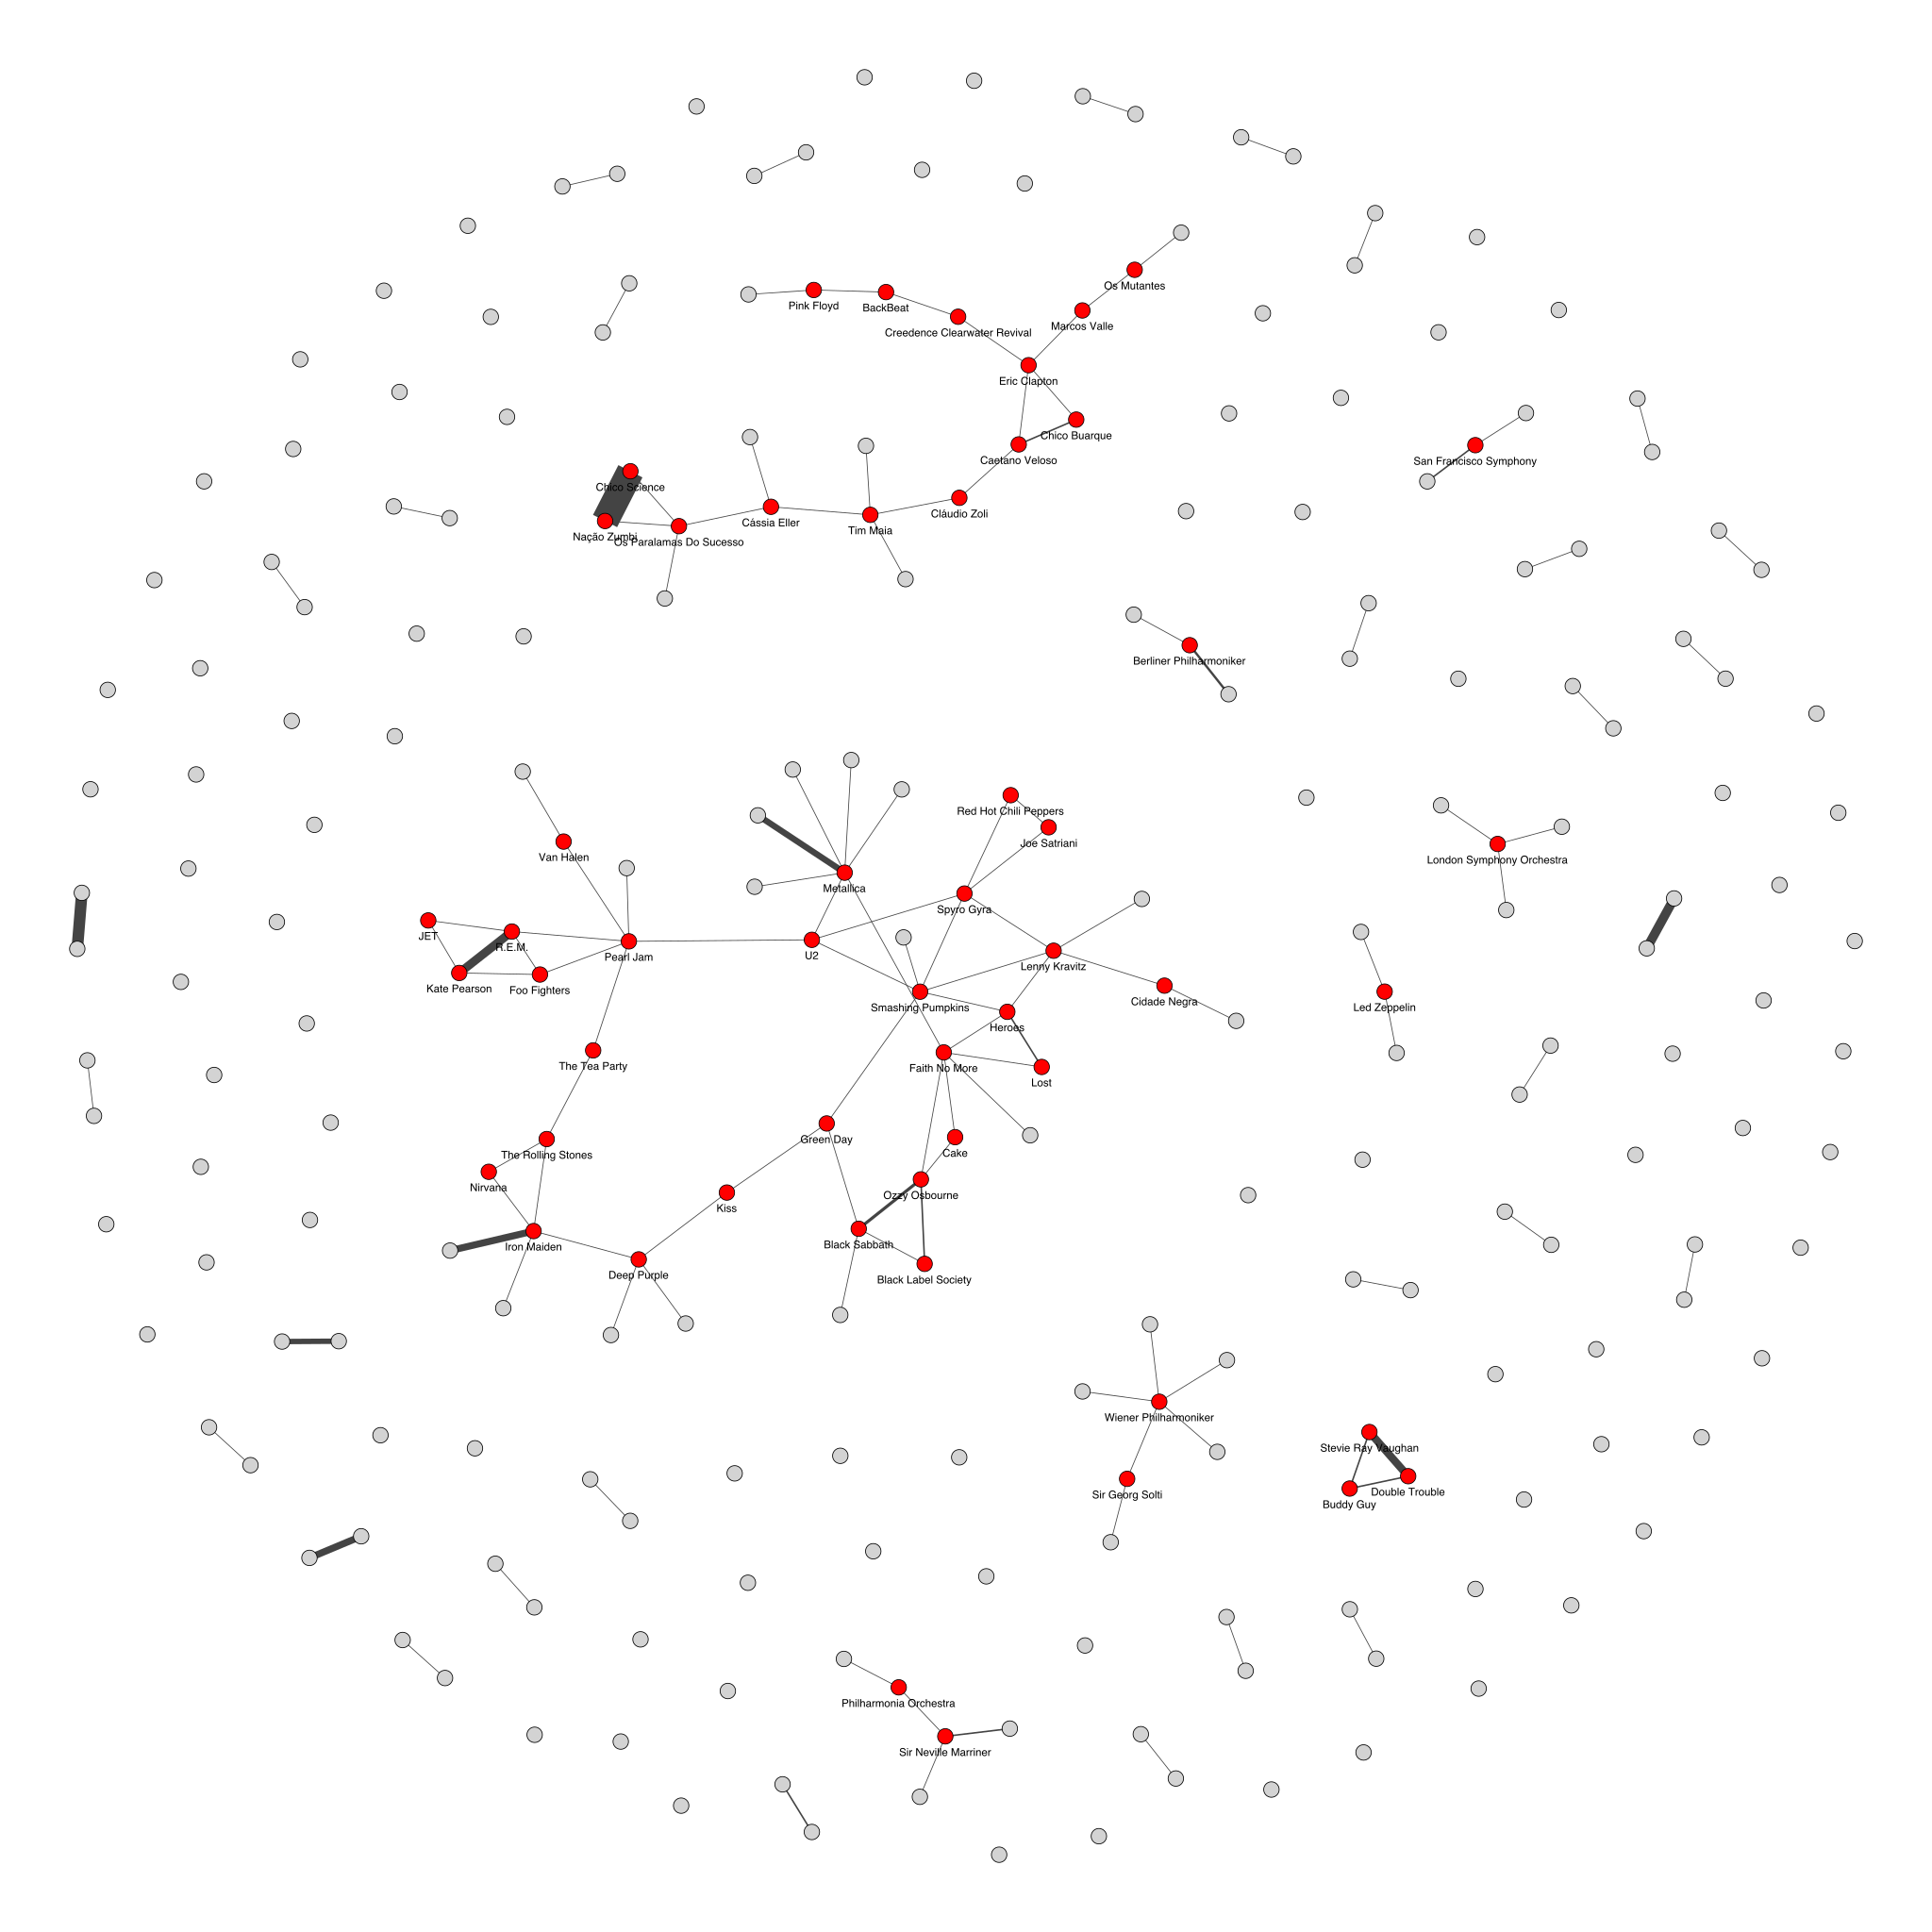

In [10]:
#https://python.igraph.org/en/0.10.8/tutorial.html#vertex-attributes-controlling-graph-plots

# Making edges thicker between artists with more collaborations
G1.es["width"] = G1.es["weight"]

degrees = G1.degree()
G1.vs["color"] = ["red" if deg >= 2 else "lightgray" for deg in degrees]
G1.vs["label"] = [name if deg >= 2 else "" for name, deg in zip(G1.vs["name"], degrees)]

layout = G1.layout("fr")
G1.vs["label_dist"] = 1.5 
ig.plot(
    G1,
    layout=layout,
    bbox=(2500, 2500),
    margin=100,
    vertex_label_dist=G1.vs["label_dist"] 
)

This visualization represents the network of musical artists and their relationship with others. I chose to use the Fruchterman-Reingold layout because I believe it does well at  organizing nodes in a way that reveals clusters. This allows us to visually identify communities and explore how subgroups within the music industry form based on genre or collaboration. To further enhance the network's readability, I scaled the thickness of the edges based on weight, which reflects the strength or frequency of relationships between artists. Thicker lines indicate stronger or more numerous connections. For instance, we see that Faith No More and Ozzy Osbourne are connected by a noticeably thick edge, suggesting repeated collaborations or deep mutual influence. This weighted edge visualization helps draw attention to the most important or meaningful ties in the network, allowing us to not only observe group structure but also understand which relationships carry more weight in shaping the network.

### Calculating node(s) with the most connnections

In [11]:
degrees = G1.degree()
max_degree = max(degrees)

most_connected_nodes = [G1.vs[i]["name"] for i, d in enumerate(degrees) if d == max_degree]

print(f"Max degree: {max_degree}")
print("Most connected nodes:", most_connected_nodes)

Max degree: 7
Most connected nodes: ['Metallica']


I calculated the degree of each node to find the artists with the most connections. Artists like Metallica have the highest degree, meaning they collaborated with many others. This suggests they are central figures in the music network and were influential in bridging different music styles. 

### Finding some large clique(s) of artists, and coloring them differently, and displaying only their names.

In [12]:
G2 = G.copy()

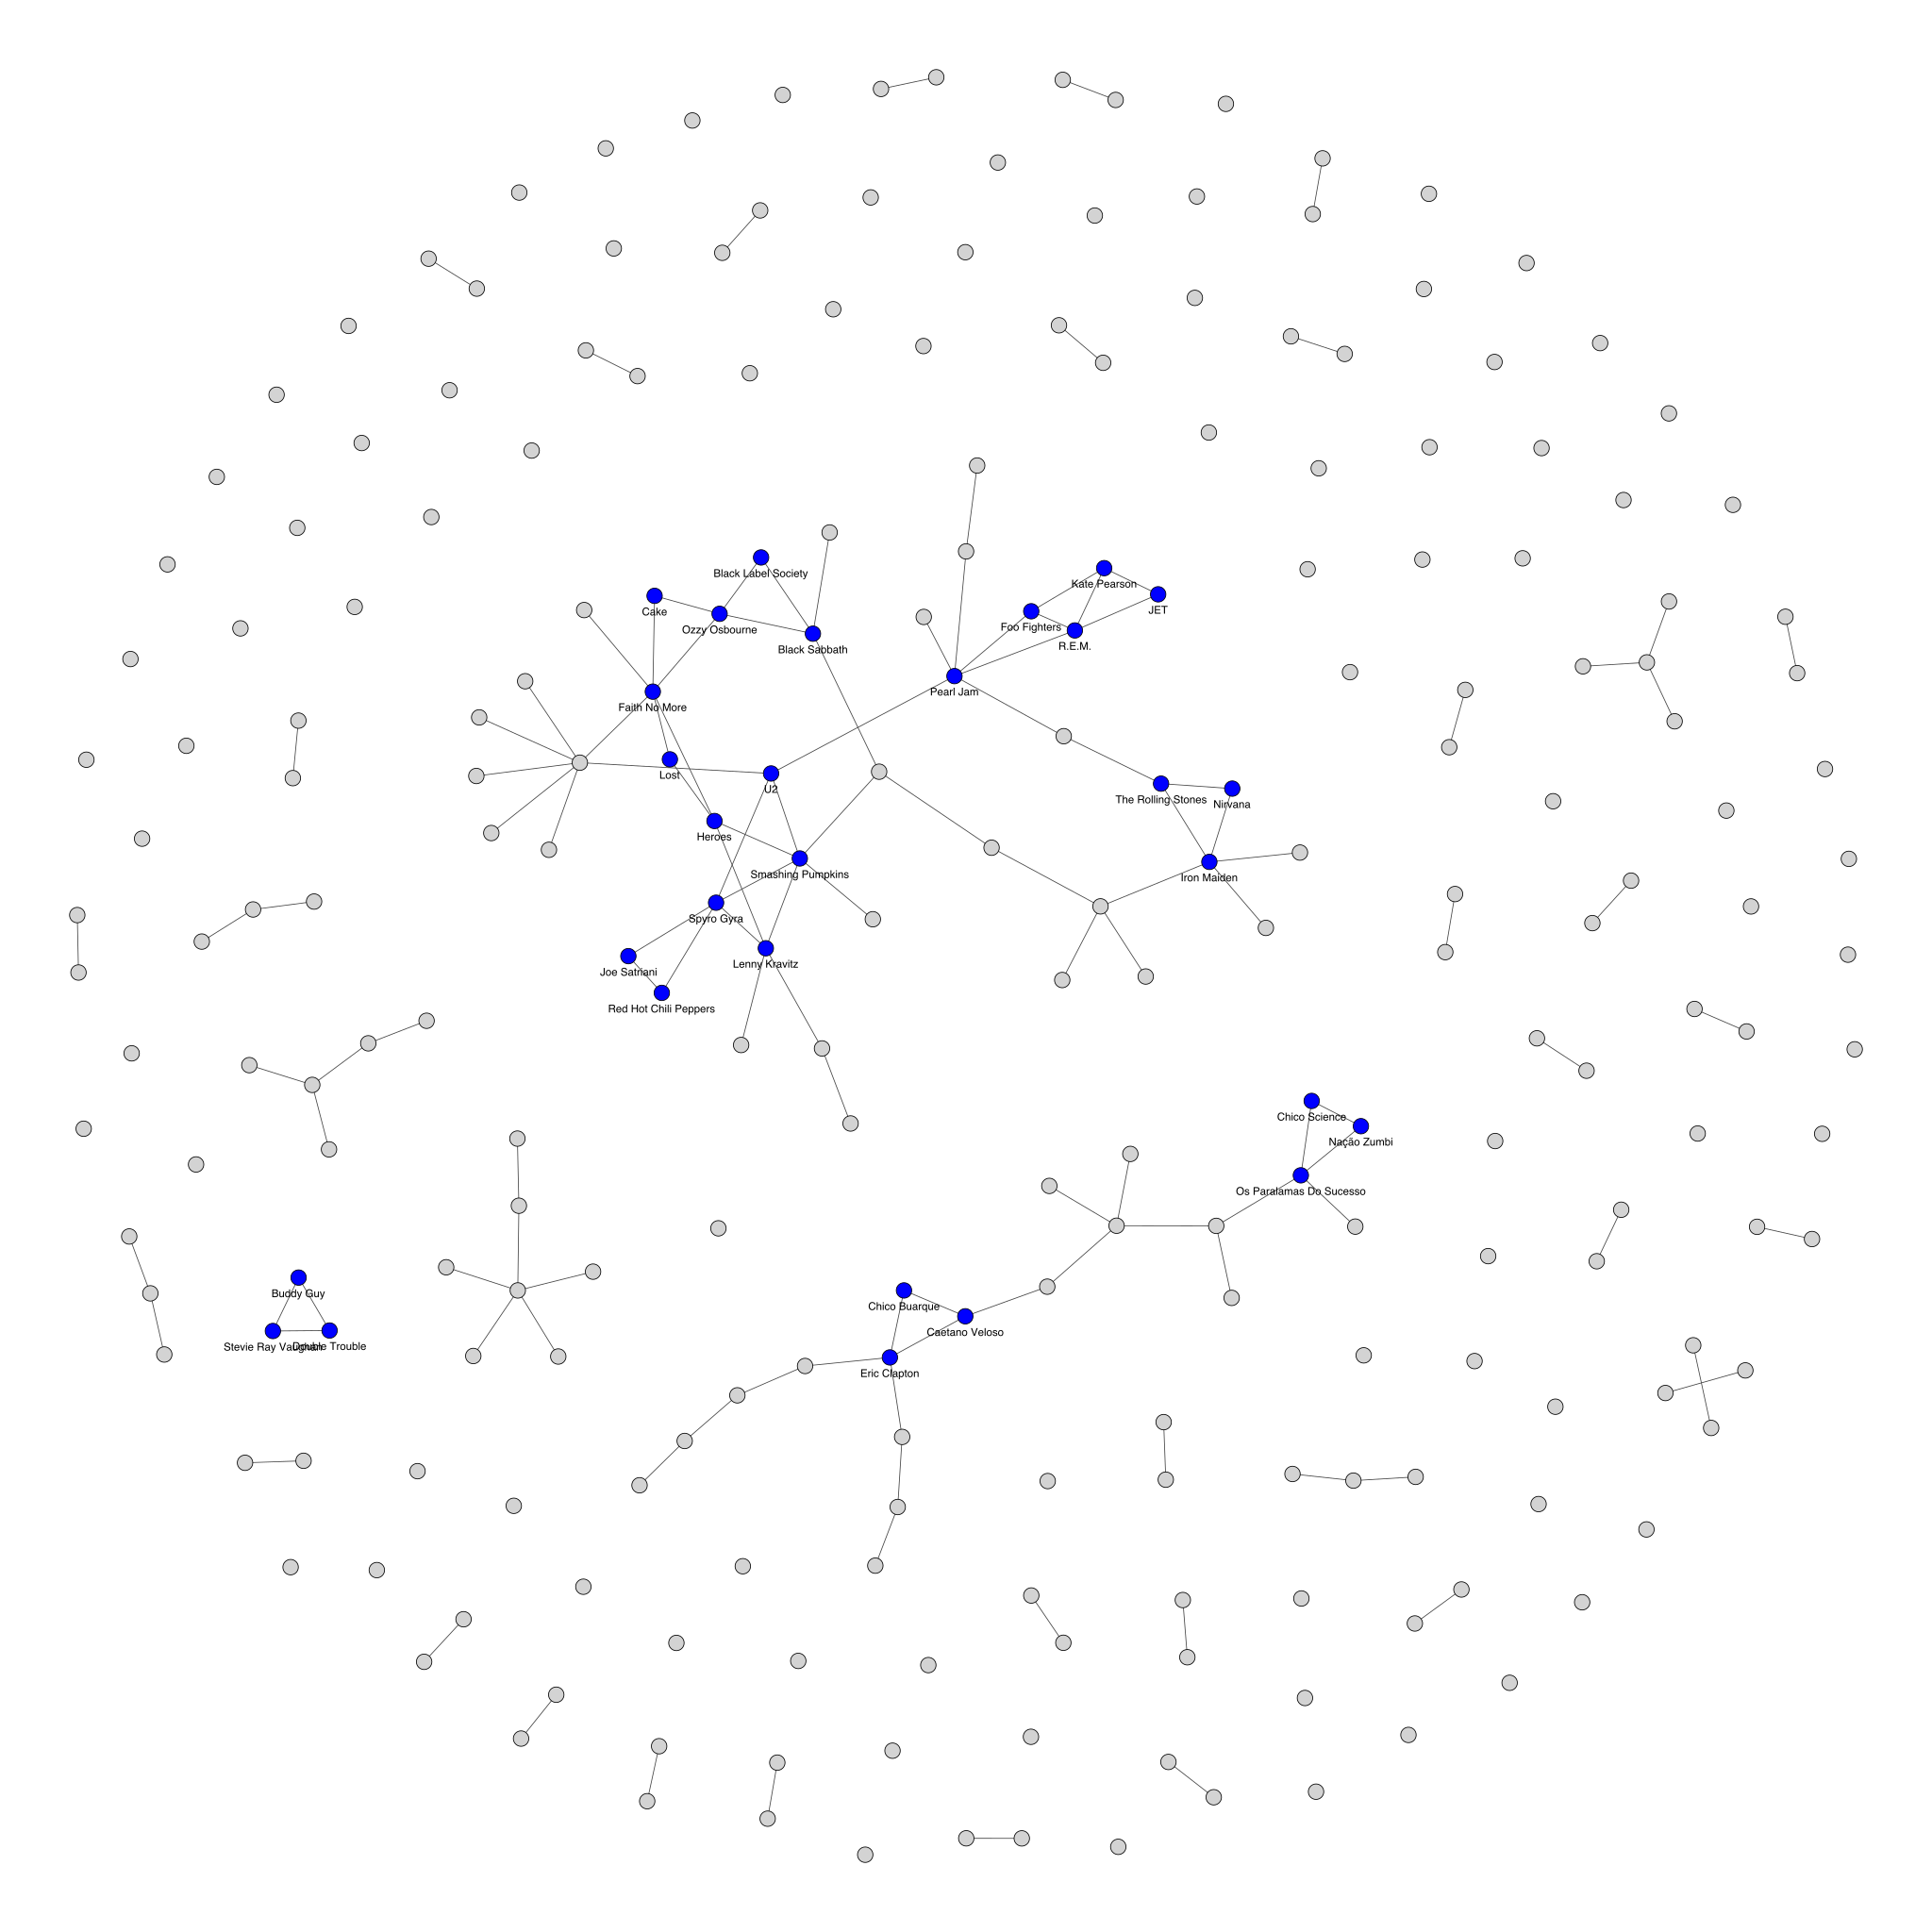

In [13]:
largest_cliques = G2.largest_cliques()
clique_nodes = set(i for clique in largest_cliques for i in clique)

G2.vs["label"] = [v["name"] if v.index in clique_nodes else "" for v in G2.vs]
G2.vs["color"] = ["blue" if v.index in clique_nodes else "lightgray" for v in G2.vs]

layout = G2.layout("fr")
G2.vs["label_dist"] = 1.5 
ig.plot(
    G2,
    layout=layout,
    bbox=(2500, 2500),
    margin=100,
    vertex_label_dist=G2.vs["label_dist"]
)

I identified the largest cliques in the network who are all directly connected to each other. The largest cliques I found consisted of only 3 artists, indicating that most tightly-knit collaborations happened in trios. In the visualization, these small, triangular clusters are highlighted in blue and appear scattered across the network, often embedded in larger communities. Many of these cliques belong to rock and alternative genres, suggesting that rock musicians tend to form close-knit collaborative groups, possibly through bands or joint performances. It was interesting to observe that no cliques larger than 3 existed, even in genres like classical or jazz, which are typically known for features and performances. This implies that while artists may be indirectly connected through shared collaborators, strong mutual ties among larger groups are rare. 

### Calculating Clique Sizes

In [14]:
from collections import Counter
cliques = G2.cliques()
clique_sizes = [len(c) for c in cliques]
clique_size_counts = Counter(clique_sizes)
clique_size_counts

Counter({1: 240, 2: 131, 3: 14})

I counted the size of all cliques in the network to see how frequently different group sizes occur. Most cliques are quite small—240 pairs (size 2) and only 14 trios (size 3)—which shows that most artists are usually limited to one other person. This suggests that while artists commonly collaborate, it's rare for them to collaborate with more than one to become large fully-connected groups.

### Including the nodes which have no edges. How many are there?

In [15]:
G3 = G.copy()

Number of nodes with no edges: 86


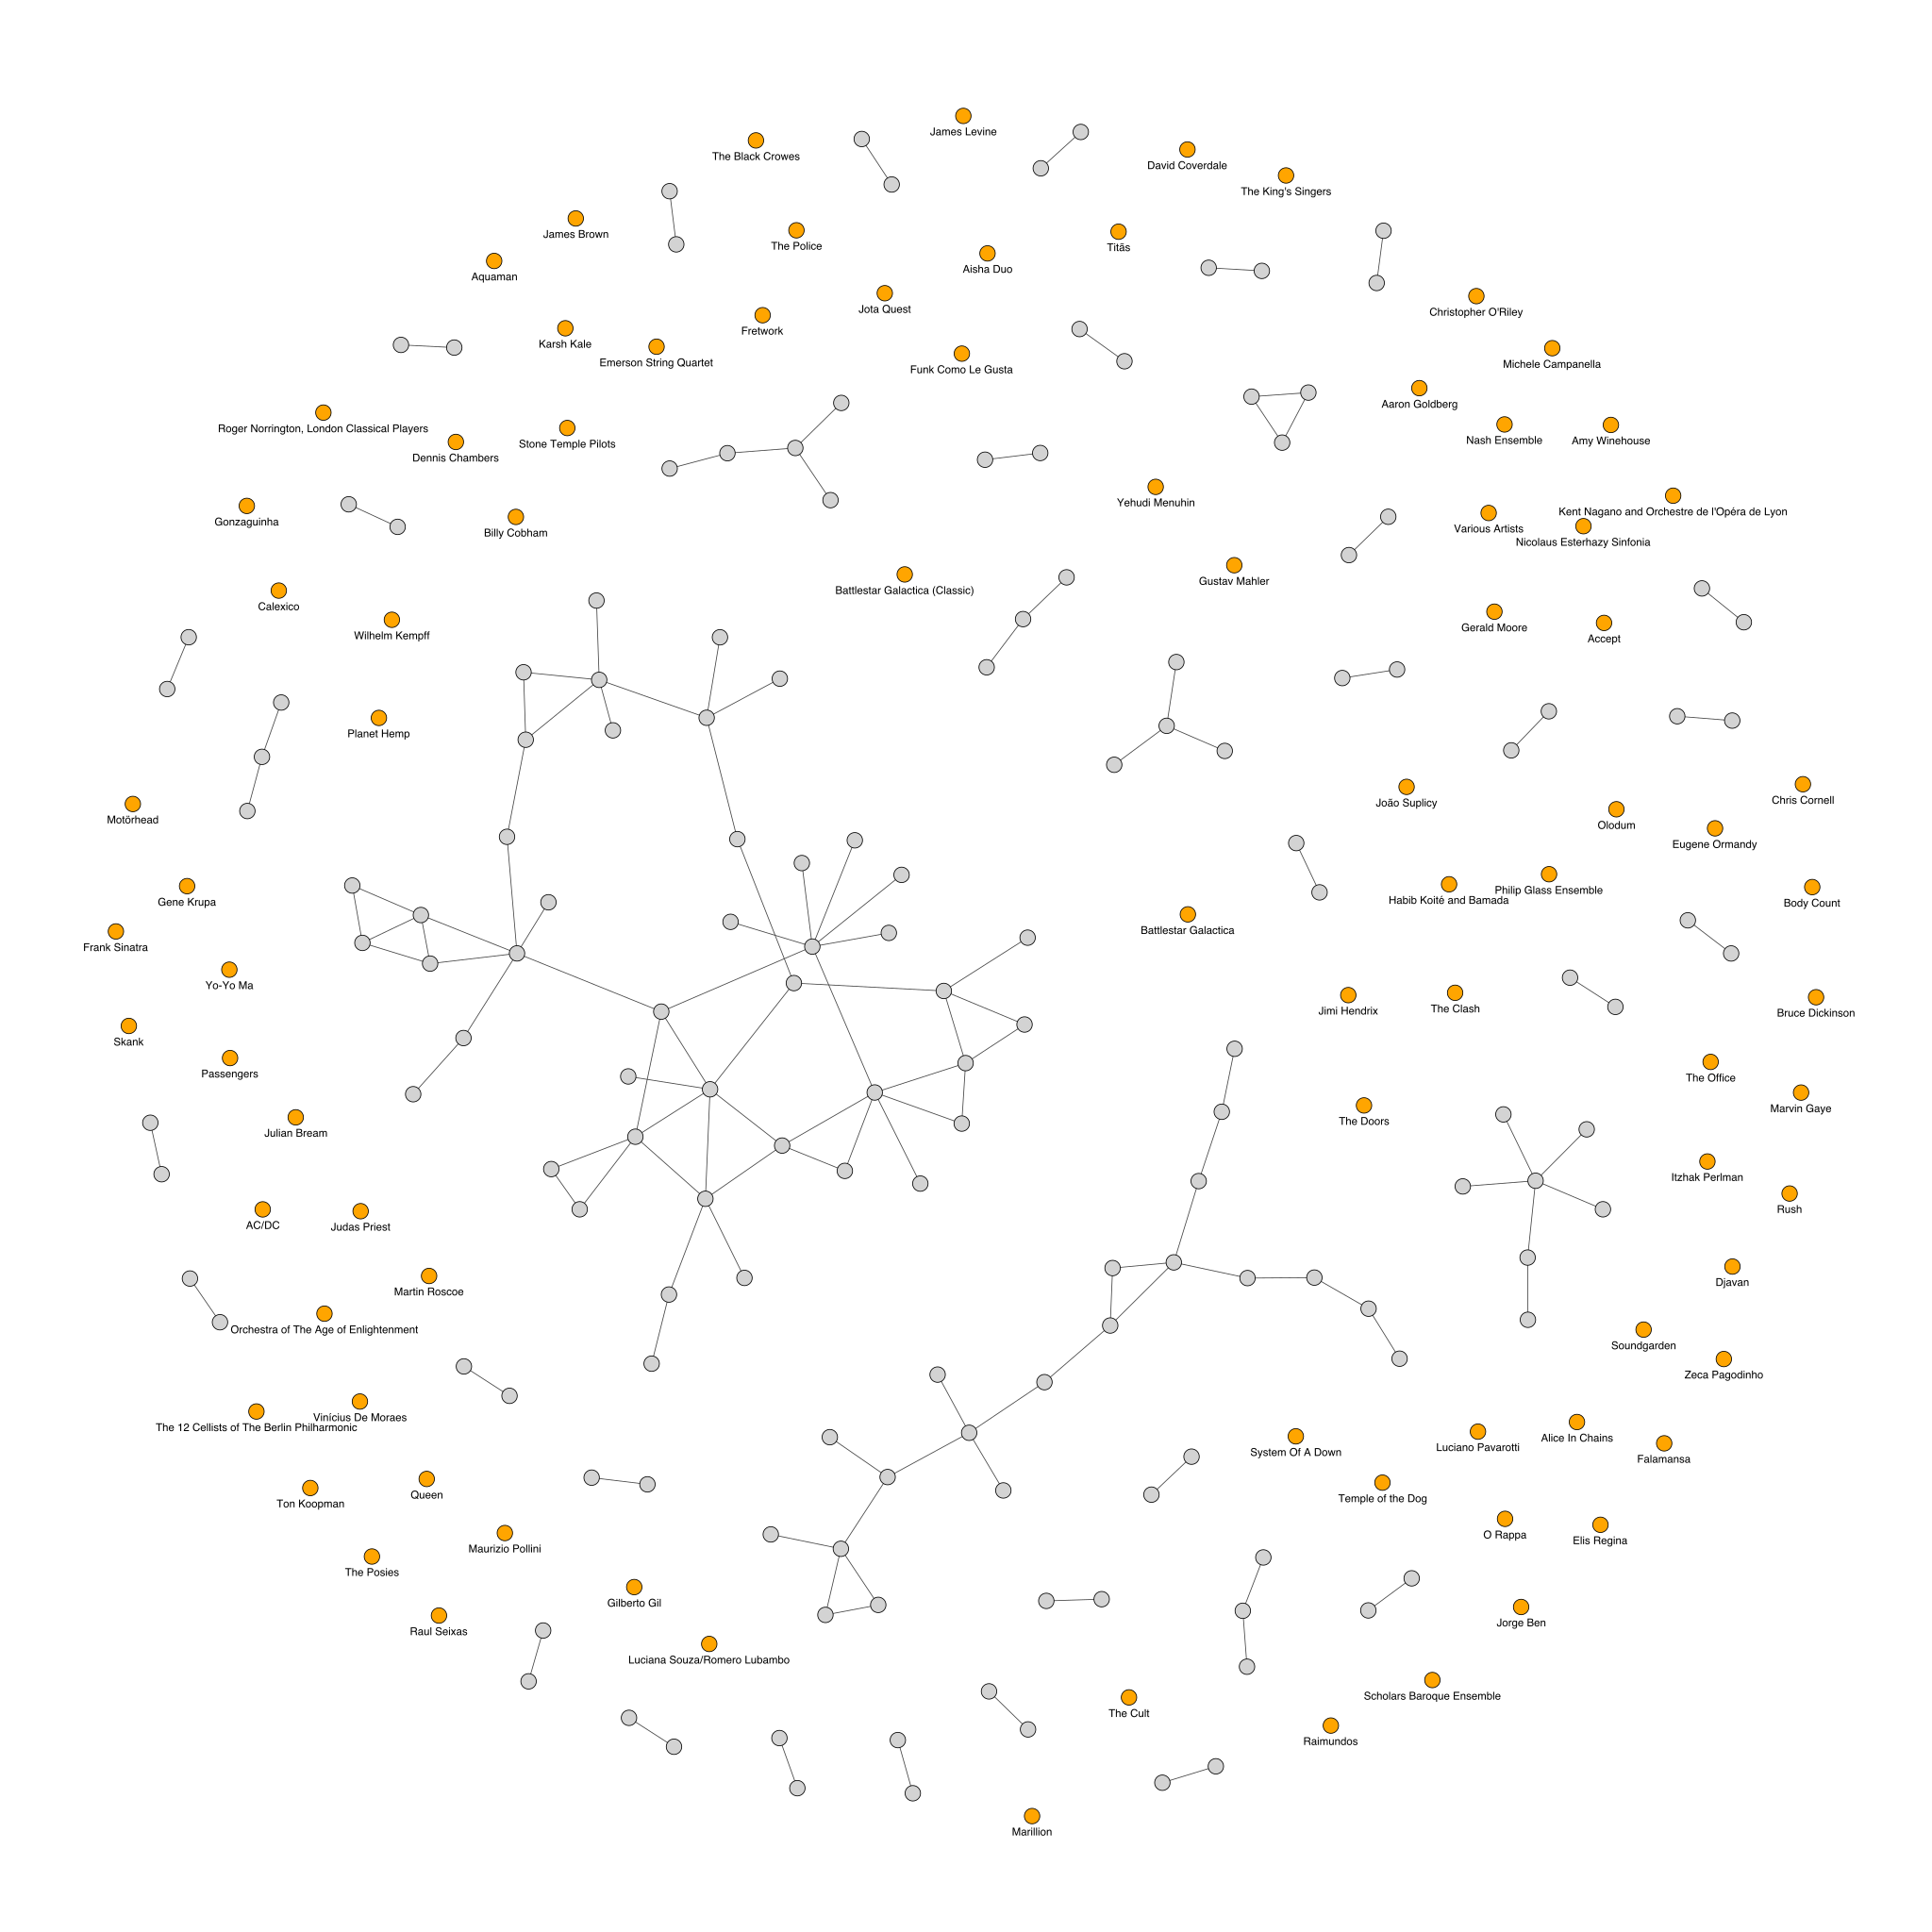

In [16]:
degrees = G3.degree()
no_edge_nodes = [i for i, deg in enumerate(degrees) if deg == 0]

G3.vs["color"] = ["orange" if i in no_edge_nodes else "lightgray" for i in range(len(G3.vs))]
G3.vs["label"] = [G3.vs[i]["name"] if i in no_edge_nodes else "" for i in range(len(G3.vs))]

print(f"Number of nodes with no edges: {len(no_edge_nodes)}")

layout = G3.layout("fr")
G3.vs["label_dist"] = 1.5 
ig.plot(
    G3, 
    layout=layout, 
    bbox=(2500, 2500), 
    margin=150,
    vertex_label_dist=G3.vs["label_dist"]
)


In this visualization, I calculated how many nodes in the network have no connections to any other nodes. These isolated nodes are often outliers—artists who don’t share collaborations or influences with others in the dataset. I found 86 such nodes, and visualized them in orange for clarity. This suggests that a portion of the network is made up of independent artists or less-documented relationships, which may either reflect how these artists really did not collaborate with anyone or just incomplete data coverage.

### Coloring the graph by clusters. What kinds of people or groups do you find?

In [17]:
G4 = G.copy()

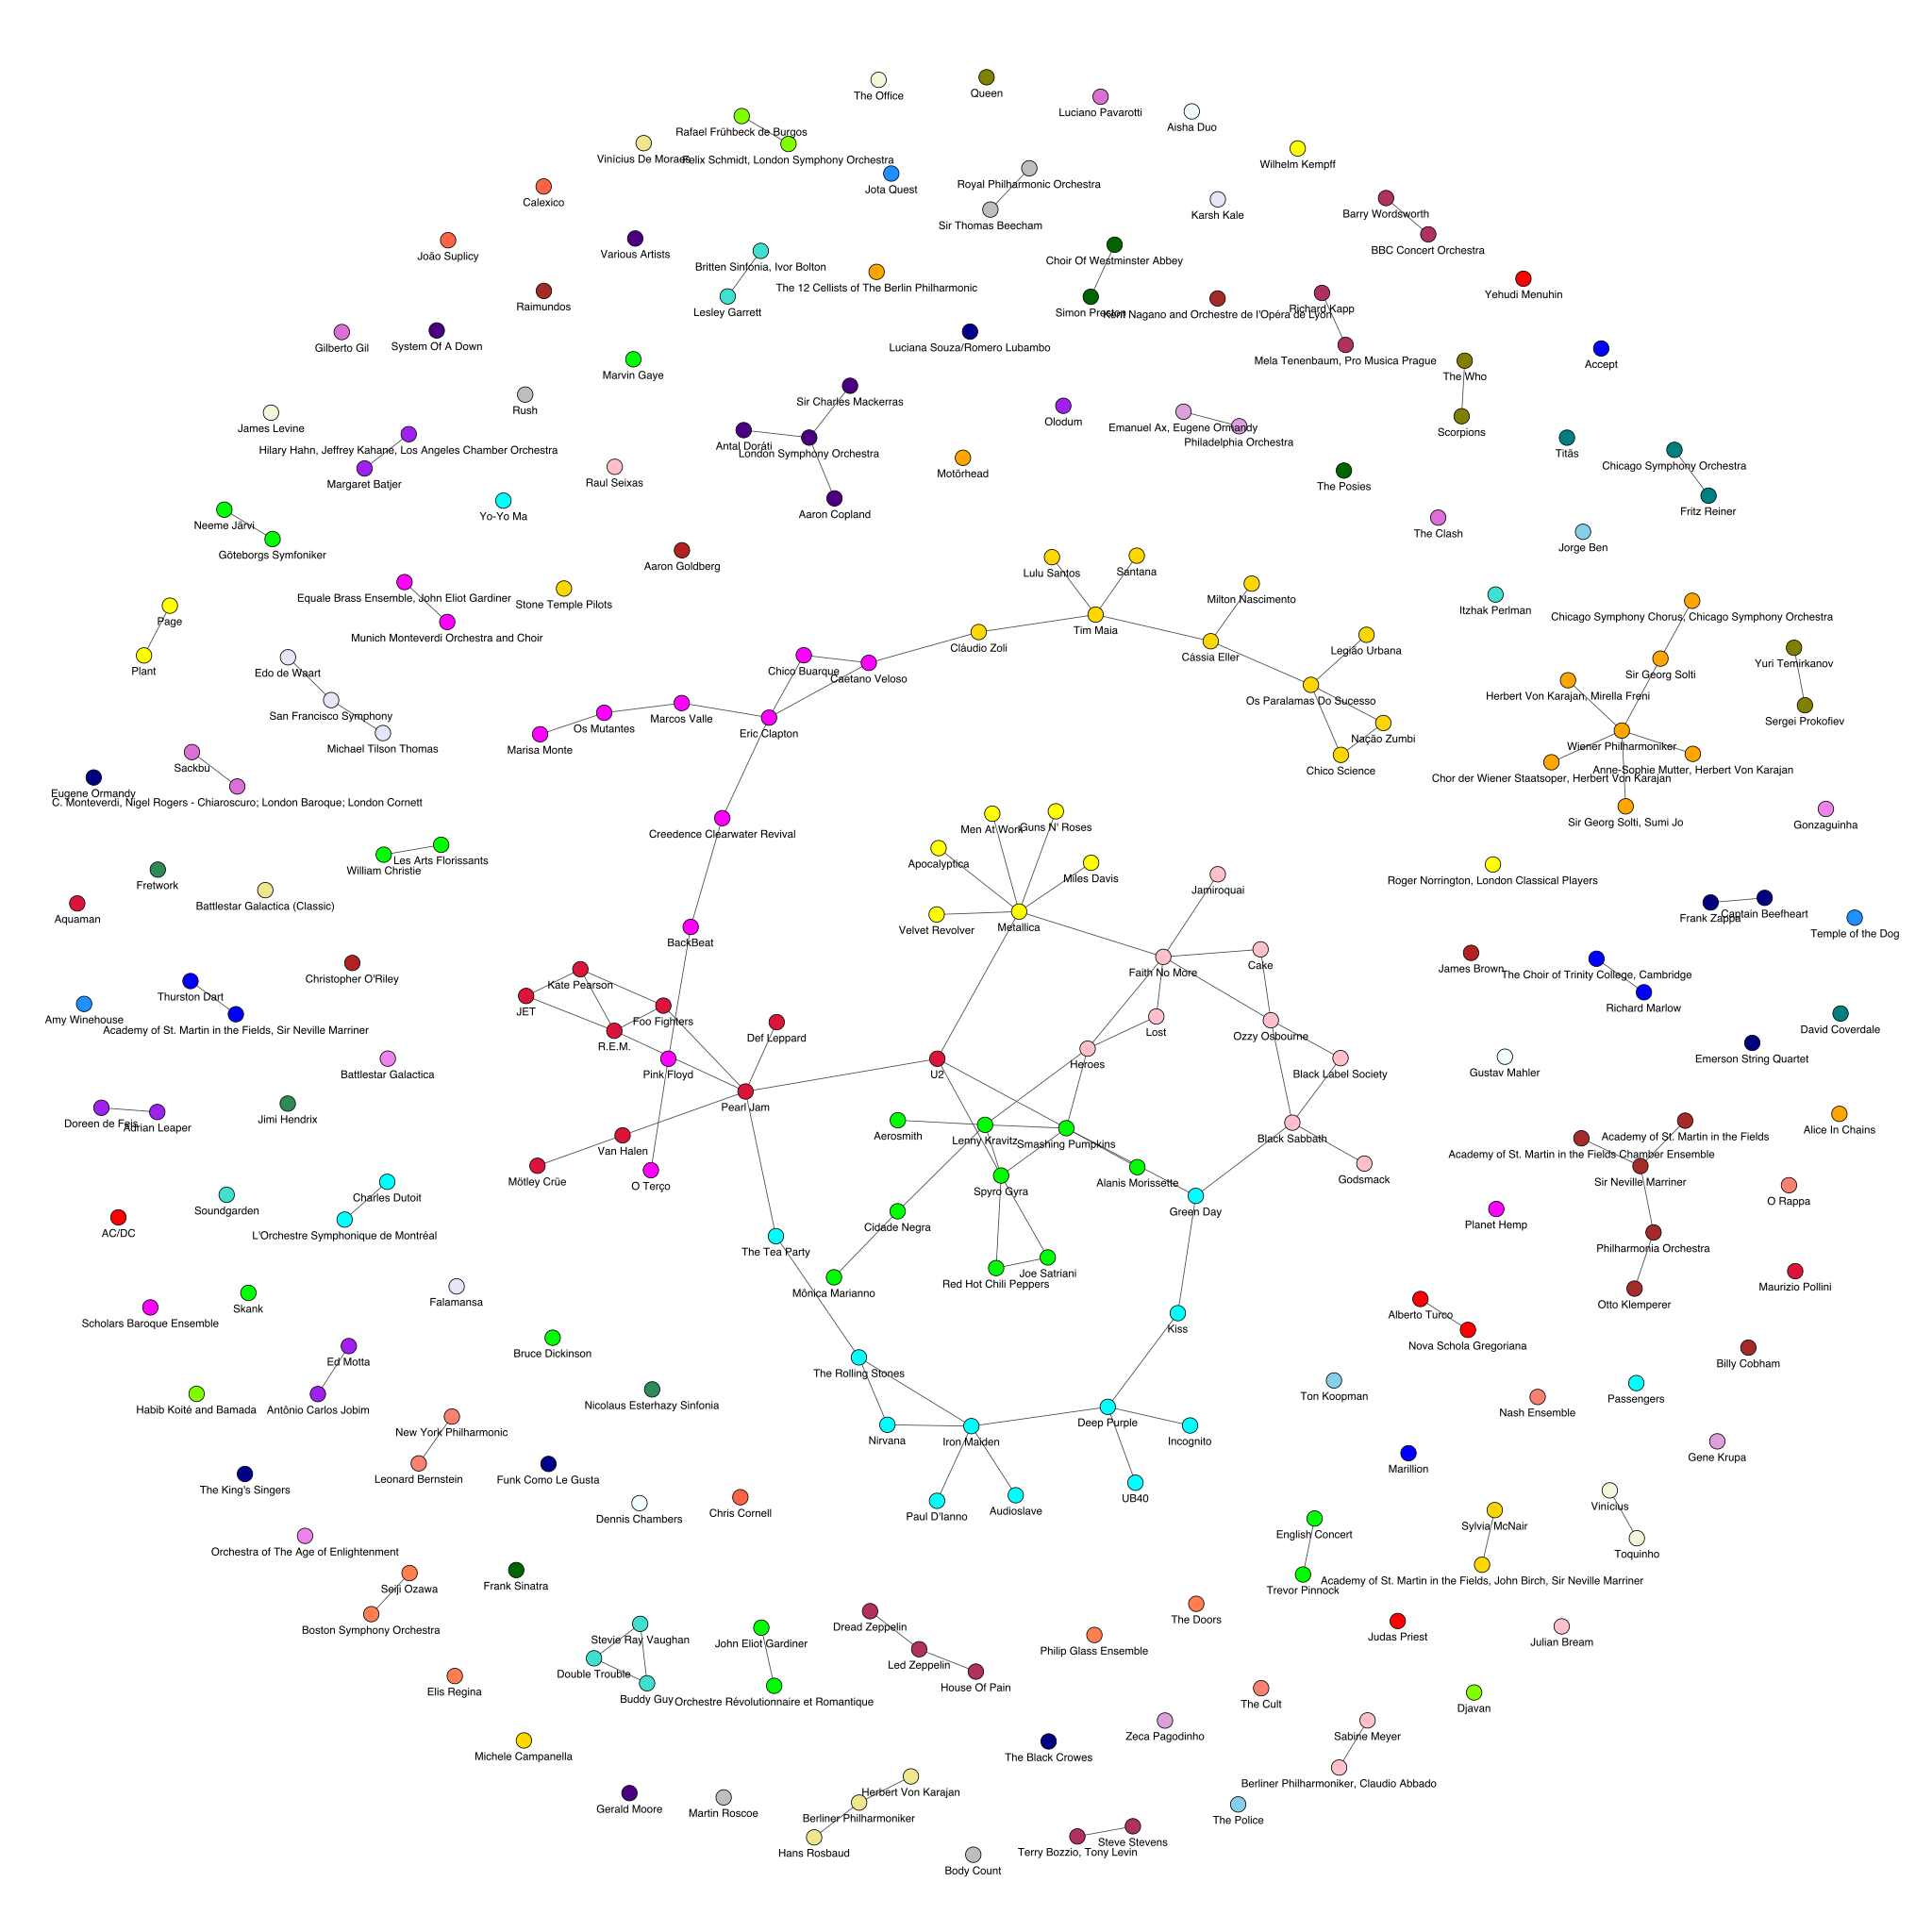

In [18]:
clusters = G4.community_multilevel()
membership = clusters.membership 

colors = [
    "red", "blue", "green", "orange", "purple", "yellow", "cyan", "magenta", 
    "brown", "pink", "gray", "lime", "turquoise", "gold", "indigo", "maroon", 
    "navy", "orchid", "salmon", "coral", "skyblue", "olive", "teal", "violet", 
    "plum", "beige", "khaki", "crimson", "azure", "chartreuse", "lavender", 
    "darkgreen", "darkblue", "firebrick", "seagreen", "dodgerblue", "tomato"
]

G4.vs["color"] = [colors[i % len(colors)] for i in membership]

layout = G4.layout("fr")
G4.vs["label_dist"] = 1.5 
G4.vs["label"] = G4.vs["name"]
ig.plot(
    G4, 
    layout=layout, 
    bbox=(2500, 2500), 
    margin=100,
    vertex_label_dist=G4.vs["label_dist"]
    )

Based on my cluster visualization, I can see several distinct communities. The teal cluster represents Brazilian artists including Caetano Veloso, Chico Buarque, and Milton Nascimento. At the center of the network is the green cluster largely represented by alternative rock and funk rock with artists like Red Hot Chili Peppers, Metallica, Lenny Kravitz, and U2. This group is defined by their genre and often collaborated or toured alongside each other, therefore creating a crossover. Other prominent clusters include the one composed of major symphony orchestras like the London Symphony Orchestra and the Vienna Philharmonic, reflecting the how these institutions are likely linked through shared conductors or ensemble participation. Another cluster, yellow cluster, consists of classic and hard rock icons like Kiss, Deep Purple, Iron Maiden, and The Rolling Stones who are probably grouped together because of shared stages, band members, and musical influence. They represent some of the most commercially successful and widely recognized rock acts globally. Overall, the pattern between these clusters can suggest that musical collaboration is often based on genre, as they share similar styles and performance practices.

### Calculating Cluster Edge Betweenness

In [19]:
clusters = G4.community_edge_betweenness()
clusters = clusters.as_clustering()

print(f"Number of clusters found: {len(clusters)}")

Number of clusters found: 131


Using the edge betweenness algorithm, I identified 131 distinct clusters within the network. This method detects community structure by progressively removing edges with the highest betweenness, acting as bridges between cluster, until well-separated groups emerge. The large number of clusters suggests that the artist network has many localized communities that are internally connected but only loosely linked to others. This reinforces the idea that musical collaboration tends to occur in tight-knit genre or regional circles.

Overarll this project showed me how network analysis can reveal hidden patterns in the music industry. I learned how to identify central figures, collaborative groups, and structural patterns like cliques. The visualizations made statistics more intuitive, and it was interesting to see how data can represent cultural relationships. I have a better understanding how genres and influence flow through networks of people.